# 1. Probabilistic downscaling of climate data over the western US with R2-D2

This colab demonstrates how to downscale coarse-resolution climate data to high resolution using the Regional Residual Diffusion-based Downscaling (R2-D2) model, a generative diffusion model introduced in Lopez-Gomez et al ([2024](
https://doi.org/10.48550/arXiv.2410.01776)). In this study, R2-D2 was trained to downscale climate projections at 45 km resolution over the western United States to a target 9 km resolution, leveraging the WUS-D3 dataset described in Rahimi et al ([2024](https://doi.org/10.5194/gmd-17-2265-2024)).

R2-D2 samples the distribution of high-resolution atmospheric fields consistent with the large-scale conditions of the input coarse-resolution data. The model is trained to emulate outputs from the dynamical model WRF, within a limited-area domain and subject to known boundary conditions. See Lopez-Gomez et al ([2024](
https://doi.org/10.48550/arXiv.2410.01776)) for an in-depth description of the generative downscaling methodology.

Performing inference (i.e., sampling) with the trained R2-D2 model requires:

- **Libraries:** R2-D2 inference requires importing the `swirl-dynamics` package, and its `gcm_wrf` project in particular. All other dependencies can be found through `pip`.
- **Pre-trained model instance:** The trained R2-D2 model can be instantiated from its configuration (a [`.gin`](https://github.com/google/gin-config) file) and its weights (an [`orbax`](https://github.com/google/orbax) checkpoint).
- **Preprocessed input data:** R2-D2 takes as input climate data at 45 km resolution from the WUS-D3 dataset, interpolated to the target 9 km grid, and with annual cumulative precipitation converted to 24 h precipitation accumulations. Pre-processed input datasets covering year 2095 of an SSP3-7.0 projection are provided in the open-source Google Cloud [bucket](https://console.cloud.google.com/storage/browser/dynamical_generative_downscaling) for all forcing Earth System Models (ESMs) considered in Lopez-Gomez et al ([2024](https://doi.org/10.48550/arXiv.2410.01776)). The pre-processing steps taken to prepare the data are documented in `gcm_wrf.input_pipelines.interpolate` and `gcm_wrf.input_pipelines.compute_precip_rates`, respectively.
- **Statistics of input and output:** R2-D2 inference requires the global statistics of the training data, used to normalize inputs and de-normalize samples from the R2-D2 model. These statistics are computed using `gcm_wrf.input_pipelines.compute_global_stats`, and they are also provided in the open-source Google Cloud bucket.

The following sections present a step-by-step demonstration of how to load the required datasets and perform inference with a pre-trained instance of the R2-D2 model.

# Selecting a runtime

Inference with R2-D2 is memory intensive and optimized for TPU and GPU accelerators. We recommend using the freely available TPU compute units to run this colab and avoid running out of RAM. GPU accelerators may also be used, provided they have enough memory.

**Enable TPU to run the notebook**

- This demo colab runs on the free hosted TPU colab kernel (v2-8 TPU).
- Navigate to the menu item `Runtime` → `Change runtime type`.
- Select `v2-8 TPU` and click `Save`.
- Click on `Connect` on the top right. You are ready once you see  `✓V28` next to the RAM & Disk display.

The default TPU kernel has 8 devices. We will leverage all 8 devices to sample 8 high-resolution fields at a time for each conditioning coarse-resolution input.

# Install dependencies

In [ ]:
!pip install zarr==2.18 gin jax matplotlib xarray gcsfs grain
!pip install git+https://github.com/google-research/swirl-dynamics.git@main
!pip install orbax-checkpoint==0.6.3
!pip install numcodecs==0.15.0

# Imports

In [ ]:
import functools
import os

import gcsfs
import gin
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from swirl_dynamics.lib import diffusion as dfn_lib
from swirl_dynamics.lib import solvers as solver_lib
from swirl_dynamics.projects import probabilistic_diffusion as dfn
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf import config_lib
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf import data_utils
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf import eval_lib
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf import inference_lib
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf import models
from swirl_dynamics.projects.probabilistic_diffusion.downscaling.gcm_wrf.input_pipelines import paired_hourly
import tensorflow as tf
import xarray as xr

gcs = gcsfs.GCSFileSystem(token='anon')

# Load downscaling model R2-D2

## Inference configuration

Here we declare:
- The path to the downscaling model.
- The path to the forcing Earth System Model (ESM) data to be downscaled. The path must point to a directory with input data, label data (used just for comparison), and statistics of the training data.
- The evaluation period and sampling frequency.
- The batch size and the number of samples per conditioning input. If a multicore computing accelerator is used (e.g., a GPU or a TPU), the number of samples per conditioning input must be equal or higher than the number of cores.
- The derived variables to generate during inference, if any. The available derived variables are defined in `gcm_wrf.eval_lib.compute_derived_field()`.

In [ ]:
# Points to the directory defining the config and weights of the model
LOGS_DIR='gs://dynamical_generative_downscaling/model'

# Points to the forcing ESM directory
FORCING_DATASET='gs://dynamical_generative_downscaling/canesm5_r1i1p2f1_ssp370_bc'

# Evaluation period covering two days for inspection purposes.
EVAL_DATE_START='2095-09-01'
EVAL_DATE_END='2095-09-02'

# Sampling frequency in hours
TIME_DOWNSAMPLE=1
# Input batch size
BATCH_SIZE=1
# Number of R2-D2 samples per condition. Must be proportional to the number of chips (8 for the TPU v2-8)
SAMPLES_PER_COND=8
# Derived variables to compute at inference time. Must be predefined in `gcm_wrf.eval_lib`
DERIVED_VARS=['RH']

# Paths to input, output, and normalization datasets
TRAINING_DATASET_STATS='gs://dynamical_generative_downscaling/canesm5_r1i1p2f1_ssp370_bc/stats'
INPUT_STATS=os.path.join(TRAINING_DATASET_STATS, 'global_hourly_2020_to_2090_d01_with_prates.zarr')
OUTPUT_STATS=os.path.join(TRAINING_DATASET_STATS, 'global_hourly_2020_to_2090_diff_d02_d01_with_prates.zarr')
INPUT_DATASET=os.path.join(FORCING_DATASET, 'hourly_d01_cubic_interpolated_to_d02_with_prates.zarr')
OUTPUT_DATASET=os.path.join(FORCING_DATASET, 'hourly_d02_with_prates.zarr')

STATIC_INPUT_DATASET=os.path.join('gs://dynamical_generative_downscaling/wrf-coordinates/wrfinput_d02.zarr')

## Instantiate downscaling sampler

The downscaling model is reconstructed from its configuration file and the weights parameterizing its neural network backbone.

We instantiate a high-resolution probabilistic sampler using the loaded downscaling model. Since the R2-D2 model outputs normalized residuals of the target fields, we configure the sampler to denormalize and add back the input to the sampled output. This way, the output samples are already full high-resolution fields with physical units.

In [ ]:
from gin import config

# Enable reading directly from Google Cloud Storage
config.register_file_reader(tf.io.gfile.GFile, tf.io.gfile.exists)

# Parse model config
config_path = os.path.join(LOGS_DIR,
                           'config_file/diff_unet_precip_ssp370_120586159_tidy.gin')
gin.parse_config_file(config_path)
dataset_config = config_lib.DatasetConfig()

# Get denoising model
denoising_model_cls = gin.get_configurable(models.DenoisingModel)
denoising_model = denoising_model_cls()

# Restore trained state from orbax checkpoint.
trained_state = dfn.DenoisingModelTrainState.restore_from_orbax_ckpt(
    f'{LOGS_DIR}/checkpoints', step=None
)
# Construct the denoiser function
denoise_fn = dfn.DenoisingTrainer.inference_fn_from_state_dict(
    trained_state, use_ema=True, denoiser=denoising_model.denoiser
)

# Recover normalization statistics for de-normalization of inference results
read_stats_fn = data_utils.read_global_stats
output_mean = read_stats_fn(
    gcs.get_mapper(OUTPUT_STATS), dataset_config.output_variables, 'mean', xr_=xr,
)
output_std = read_stats_fn(
    gcs.get_mapper(OUTPUT_STATS), dataset_config.output_variables, 'std', xr_=xr,
)

# Recover sampler
sampler = models.SdeSampler(
      input_shape=dataset_config.output_shape,
      integrator=solver_lib.EulerMaruyama(),
      tspan=dfn_lib.edm_noise_decay(
          denoising_model.diffusion_scheme,
          # Increasing num_steps leads to more accurate results, at higher computational cost.
          num_steps=denoising_model.num_sde_steps,
      ),
      scheme=denoising_model.diffusion_scheme,
      denoise_fn=denoise_fn,
      guidance_transforms=(
          # guidance_strength improves some metrics at the cost of diversity.
          dfn_lib.ClassifierFreeHybrid(guidance_strength=denoising_model.cg_strength),
      ),
      apply_denoise_at_end=True,
      return_full_paths=False,
      rescale_mean=output_mean,
      rescale_std=output_std,
  )
input_indices = [
    dataset_config.input_variables.index(varname)
    for varname in dataset_config.output_variables
]
input_mean = read_stats_fn(gcs.get_mapper(INPUT_STATS), dataset_config.input_variables, 'mean', xr_=xr,)
input_std = read_stats_fn(gcs.get_mapper(INPUT_STATS), dataset_config.input_variables, 'std', xr_=xr,)
sampling_fn = functools.partial(
    sampler.generate_denormalize_and_add_input,
    input_indices,
    input_mean,
    input_std,
)

# Finally, we instantiate the generative sampler function.
# eval_lib.batch_inference distributes the inference task across devices.
generate = functools.partial(
    eval_lib.batch_inference, sampling_fn, SAMPLES_PER_COND)

# Instantiate data loader

Once the sampler has been instantiated, we configure and instantiate a input data loader to pass batches of data to the sampler.

In [ ]:
# Dataset selection and serving config
date_range = (EVAL_DATE_START, EVAL_DATE_END)
source_kwargs = {
    'date_range': date_range,
    'input_dataset': gcs.get_mapper(INPUT_DATASET),
    'input_variables': dataset_config.input_variables,
    'output_dataset': gcs.get_mapper(OUTPUT_DATASET),
    'output_variables': dataset_config.output_variables,
    'static_input_dataset': gcs.get_mapper(STATIC_INPUT_DATASET),
    'static_input_variables': dataset_config.static_input_variables,
    'time_downsample': TIME_DOWNSAMPLE,
    'resample_at_nan': False,
    'resample_seed': 42,
    'xr_': xr,
}

source = paired_hourly.DataSource(**source_kwargs)
source_times = source.get_dates()

loader = paired_hourly.create_dataset(
    **source_kwargs,
    input_stats=gcs.get_mapper(INPUT_STATS),
    output_stats=None,  # We want to recover targets without normalization.
    random_maskout_probability=0.0,
    shuffle=False, # we load data sequentially, without random shuffling.
    seed=42,
    batch_size=BATCH_SIZE,
    drop_remainder=True,
    worker_count=0,
    normalization=dataset_config.normalization,
)

# Sampling downscaled climate fields with R2-D2

Recall that the R2-D2 model presented in Lopez-Gomez et al ([2024](
https://doi.org/10.48550/arXiv.2410.01776)) takes as input climate data over the western US at 45 km resolution, interpolated to a 9 km grid, and outputs climate data at 9 km resolution.

Here, we sample 9 km resolution fields from the loaded R2-D2 model, and also retain the WRF 9 km fields for comparison. Running this section of the colab can take up to 5 minutes.

In [ ]:
# Fetch data batch
data_iter = iter(loader)
batch = next(data_iter)
batch = jax.tree.map(lambda x: x.compute(), batch)
batch_id = 0

# Sample distribution of downscaled fields
generated_samples = jax.vmap(generate, in_axes=(0, 0))(
    batch, jax.random.split(jax.random.PRNGKey(456), BATCH_SIZE)
)
# The output has shape (batch_size, num_devices, ...).
# Reshape to eliminate TPU number of devices dimension (which is 8 for TPU v2-8)
generated_samples = jnp.reshape(
    generated_samples, (-1,) + generated_samples.shape[2:]
)
# Recover dates
times = source_times[
        range(BATCH_SIZE * batch_id, BATCH_SIZE * (batch_id + 1))
    ]
# Evaluate any requested derived variables.
if DERIVED_VARS:
  derived_samples = eval_lib.get_derived_fields(
      generated_samples,
      dataset_config.output_variables + DERIVED_VARS,
  )
  generated_samples = jnp.concatenate(
      (generated_samples, derived_samples), axis=-1
  )
# Convert output samples to xarray.Dataset
inference_ds = inference_lib.samples_to_dataset(
    generated_samples,
    field_names=dataset_config.output_variables + DERIVED_VARS,
    times=times)

# Get input and target for the same date for inspection
input_mean = read_stats_fn(
    gcs.get_mapper(INPUT_STATS),
    dataset_config.input_variables,
    'mean',
    xr_=xr,
)
input_std = read_stats_fn(
    gcs.get_mapper(INPUT_STATS),
    dataset_config.input_variables,
    'std',
    xr_=xr,
)
inputs = batch['cond']['channel:input'] * input_std + input_mean
targets = batch['x']

# Compute derived fields from input and output fields for comparison
if DERIVED_VARS:
  derived_inputs = eval_lib.get_derived_fields(
      inputs,
      dataset_config.input_variables + DERIVED_VARS,
  )
  inputs = jnp.concatenate((inputs, derived_inputs), axis=-1)

  derived_targets = eval_lib.get_derived_fields(
      targets,
      dataset_config.output_variables + DERIVED_VARS,
  )
  targets = jnp.concatenate((targets, derived_targets), axis=-1)

# Package inputs and outputs as xarray.Datasets
input_ds = inference_lib.batch_to_dataset(
    inputs,
    field_names=dataset_config.input_variables + DERIVED_VARS,
    times=times,
)

targets_ds = inference_lib.batch_to_dataset(
    targets,
    field_names=dataset_config.output_variables + DERIVED_VARS,
    times=times,
)

# Inspecting the samples

The sampled high-resolution fields are stored in an xarray.Dataset with units `(time, sample, south_north, west_east)`. The last two axes are spatial dimensions and differ from latitude and longitude. Each spatial location in the grid denotes the average value covering a square area with a 9 km side length, mimicking the WRF discretization used to generate the training data. The full domain has 340 x 270 grid points.

The inputs and outputs are stored similarly, with the only exception that they lack the `sample` dimension.

In [ ]:
print('Inference batch:')
print(inference_ds, '\n')

print('Conditioning input used to generate the data:')
print(input_ds, '\n')

print('Matching WRF label:')
print(targets_ds, '\n')

Inference batch:
<xarray.Dataset> Size: 21MB
Dimensions:      (time: 1, sample: 8, south_north: 340, west_east: 270)
Coordinates:
  * time         (time) datetime64[ns] 8B 2095-09-01
  * sample       (sample) int64 64B 0 1 2 3 4 5 6 7
  * south_north  (south_north) int64 3kB 0 1 2 3 4 5 ... 334 335 336 337 338 339
  * west_east    (west_east) int64 2kB 0 1 2 3 4 5 6 ... 264 265 266 267 268 269
Data variables:
    T2           (time, sample, south_north, west_east) float32 3MB ...
    Q2           (time, sample, south_north, west_east) float32 3MB ...
    U10          (time, sample, south_north, west_east) float32 3MB ...
    V10          (time, sample, south_north, west_east) float32 3MB ...
    PSFC         (time, sample, south_north, west_east) float32 3MB ...
    RAIN_24h     (time, sample, south_north, west_east) float32 3MB ...
    RH           (time, sample, south_north, west_east) float32 3MB ...
Attributes:
    description:  Conditionally downscaled samples. 

Conditioning inpu

# Plotting the R2-D2 samples, the WRF downscaled fields, and the input

Here, we plot samples from the generative model, samples taken directly from WRF (the emulated target), and the coarse-resolution input. Two samples from R2-D2 are drawn for the same inputs and plotted, to demonstrate the ability of the generative model to probe the downscaling uncertainty.

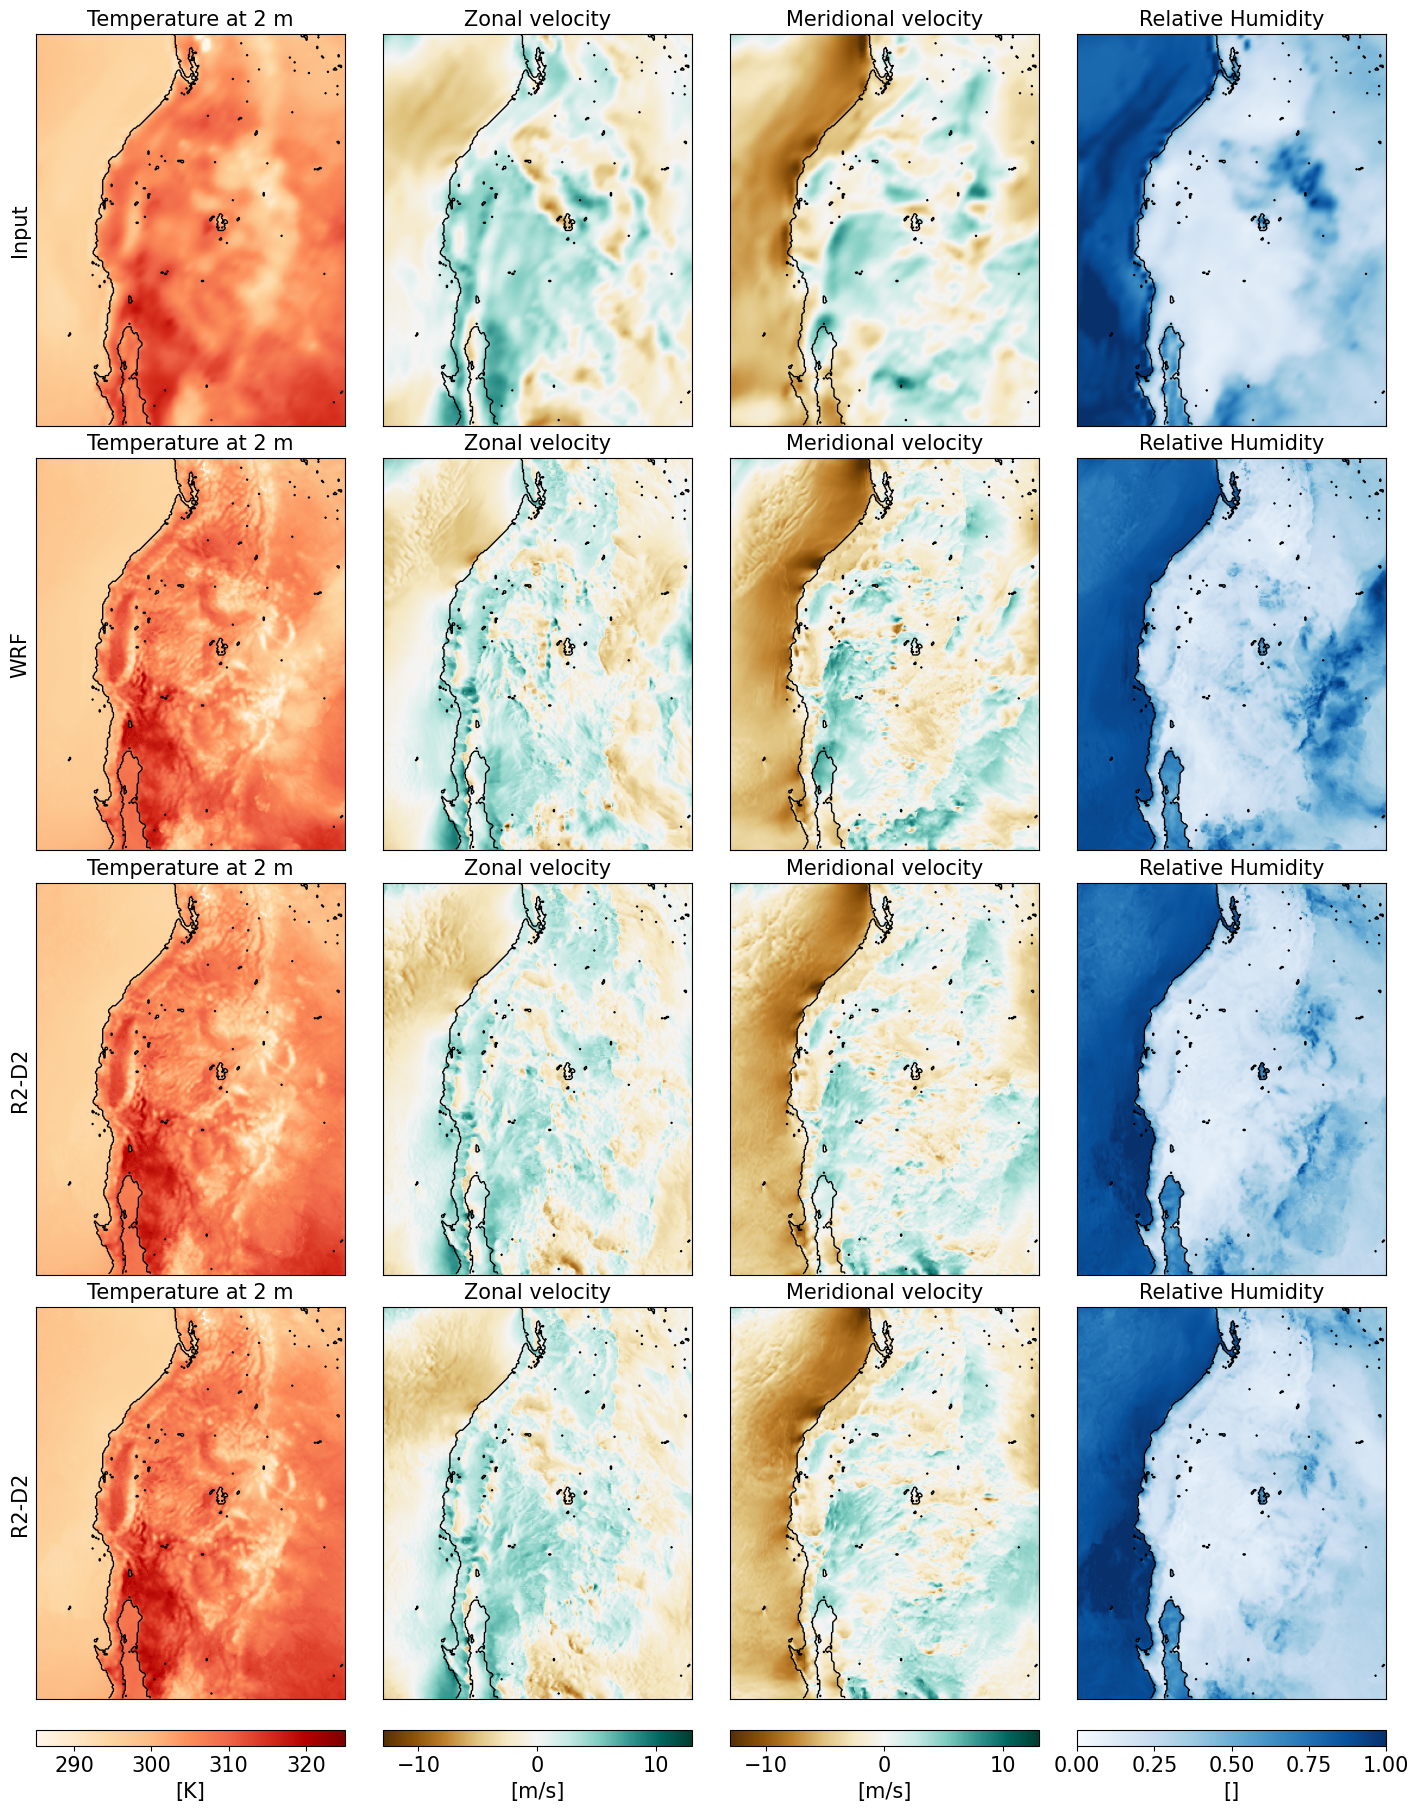

In [ ]:
# Number of generative samples
num_samples = 2
# Number of plots: generative samples, input + output
num_column_plots = num_samples + 2
# Crop sponge layer from figures
crop = 5
# Fields to be plotted
fields = ['T2', 'U10', 'V10', 'RH']
num_fields = len(fields)

## Land mask
static_ds = xr.open_zarr(gcs.get_mapper(STATIC_INPUT_DATASET))
levels = [0.5]
landmask = static_ds['LANDMASK'].values[crop: -crop, crop: -crop]

# Plot ranges and annotations
val_dict = {'T2': 20.0, 'Q2': 1.1, 'U10': 13, 'V10': 13,  'RAIN_24h': 5.0, 'RH': 1.0}
units_dict = {'T2': 'K', 'Q2': 'g/kg', 'U10': 'm/s', 'V10': 'm/s', 'RAIN_24h': 'mm/d', 'PSFC': 'hPa', 'RH': ''}
nice_varnames = {'T2': 'Temperature at 2 m', 'Q2': 'Specific humidity at 2 m', 'U10': 'Zonal velocity', 'V10': 'Meridional velocity',
                 'RAIN_24h': 'Precipitation', 'PSFC': 'Surface pressure', 'RH': 'Relative Humidity'}
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
fontsize = 15

height_ratios = [25] * (num_column_plots + 1)
height_ratios[-1] = 1
fig, ax = plt.subplots(num_column_plots+1, num_fields, figsize=(4.5*(270/340)*num_fields, 4.5*(num_column_plots+1.0/height_ratios[0])), gridspec_kw={'height_ratios': height_ratios})

for field_id, field in enumerate(fields):
  vmin = -val_dict[field]
  vmax = val_dict[field]
  cmap = 'BrBG'
  if field == 'RAIN_24h' or field == 'RH':
    vmin = 0
    cmap = 'Blues'
  if field == 'T2':
    cmap = 'OrRd'
    vmin = vmin + 305
    vmax = vmax + 305

  # Get fields
  input_field = input_ds[field].isel(time=0)
  target_field = targets_ds[field].isel(time=0)
  samples_field = inference_ds[field].isel(time=0).isel(sample=slice(0, num_samples))

  # Plot input
  im = ax[0, field_id].imshow(input_field[crop:-crop, crop:-crop], origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
  ax[0, field_id].contour(landmask, origin='lower', levels=levels, cmap='gist_gray', linewidths=1)
  ax[0, field_id].set_title(f'{nice_varnames[field]}', size=fontsize)
  # Omit axes
  ax[0, field_id].set_xticks([])
  ax[0, field_id].set_yticks([])
  ax[0, 0].set_ylabel('Input', size=fontsize)

  # Plot target (WRF)
  im = ax[1, field_id].imshow(target_field[crop:-crop, crop:-crop], origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
  ax[1, field_id].contour(landmask, origin='lower', levels=levels, cmap='gist_gray', linewidths=1)
  ax[1, field_id].set_title(f'{nice_varnames[field]}', size=fontsize)
  # Omit axes
  ax[1, field_id].set_xticks([])
  ax[1, field_id].set_yticks([])
  ax[1, 0].set_ylabel('WRF', size=fontsize)

  # Plot R2-D2 samples
  for i in range(2, num_samples+2):
    im = ax[i, field_id].imshow(samples_field.isel(sample=i-2)[crop:-crop, crop:-crop], origin='lower', vmin=vmin, vmax=vmax, cmap=cmap)
    ax[i, field_id].contour(landmask, origin='lower', levels=levels, cmap='gist_gray', linewidths=1)
    ax[i, field_id].set_title(f'{nice_varnames[field]}', size=fontsize)
    ax[i, 0].set_ylabel(f'R2-D2', size=fontsize)
    ax[i, field_id].set_xticks([])
    ax[i, field_id].set_yticks([])

  cbar = fig.colorbar(im, cax=ax[num_column_plots, field_id], orientation='horizontal')
  cbar.set_label(label=f'[{units_dict[field]}]', size=fontsize)
  cbar.ax.tick_params(labelsize=fontsize)

fig.subplots_adjust(wspace=0.12, hspace=0.05)
plt.tight_layout()